In [123]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

In [124]:

transform = v2.Compose(
    [
        v2.Resize([64,64]),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = torchvision.datasets.CelebA(root="./dataset", split="train", transform=transform, download=True)
test_dataset = torchvision.datasets.CelebA(root="./dataset", split="test", transform=transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 64, 64])


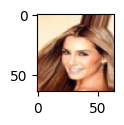

In [125]:
print(train_dataset[0][0].shape)
train_dataset[0][0]
plt.figure(figsize=(1,1))
plt.imshow(train_dataset[0][0].permute([1, 2, 0]))

In [126]:
class Sampling(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, z_mean, z_log_var):
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        epsilion = torch.randn([batch, dim])
        epsilion = epsilion.to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilion

class Encoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1
        )  # 32 x 32
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1
        )  # 16 x 16
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(  
            in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1
        )  # 8 x 8
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(  
            in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1
        )  # 4 x 4
        self.bn4 = nn.BatchNorm2d(128)
        self.activation = nn.LeakyReLU()

        self.flatten = nn.Flatten()
        self.dense_z_mean = nn.Linear(in_features=128 * 4 * 4, out_features=200)
        self.dense_z_log_var = nn.Linear(in_features=128 * 4 * 4, out_features=200)
        self.sampling = Sampling()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.activation(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.activation(out)
        out = self.flatten(out)
        
        z_mean = self.dense_z_mean(out)
        z_log_var = self.dense_z_log_var(out)
        z = self.sampling(z_mean, z_log_var)

        return z_mean, z_log_var, z

encoder = Encoder()
sample = train_dataset[0][0].unsqueeze(0)
print(sample.shape)
z_mean, z_log_var, z = encoder(sample)
print('z_mean:', z_mean)
print('z_log_var:', z_log_var)
print('z:', z)


torch.Size([1, 3, 64, 64])
z_mean: tensor([[-4.5814e-01,  1.1868e-01,  1.1882e-01,  1.2674e-02, -3.7062e-01,
          7.9905e-02,  4.4283e-01, -7.3753e-01, -2.3258e-01,  4.1290e-02,
         -2.6326e-01,  6.5294e-01,  4.1810e-02,  8.1187e-01, -9.7447e-01,
          1.5391e-01,  4.0189e-01, -5.1202e-01, -4.3488e-02, -8.5897e-02,
         -3.7432e-01, -1.2987e-02, -1.6729e-01,  6.2790e-02,  1.2862e-01,
         -3.5390e-01,  1.1235e-01,  3.0658e-01, -3.3550e-01,  1.9130e-01,
          6.3571e-02, -2.4651e-01,  1.6416e-01, -3.1532e-01, -4.0565e-01,
         -5.0054e-01, -1.9182e-01, -3.5810e-01, -6.2761e-01, -2.2752e-01,
         -3.6136e-02,  4.3638e-01,  4.2881e-01,  7.5045e-02, -6.0274e-01,
          6.5110e-01, -2.7471e-01,  6.4313e-01,  5.7338e-01, -7.6215e-03,
         -2.4139e-01,  4.4552e-02,  3.5120e-01, -2.6547e-01,  4.5704e-01,
          4.9745e-01,  6.5927e-01, -8.6188e-02, -5.6279e-01, -1.0384e-01,
         -7.2198e-01, -6.9542e-01, -4.6815e-01, -3.5573e-01,  8.8244e-02,
   

In [127]:
class Decoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dense = nn.Linear(in_features=200, out_features=128 * 4 * 4)
        self.bn_dense = nn.BatchNorm1d(128*4*4)
        self.conv_tr1 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.bn1 = nn.BatchNorm2d(128)
        self.conv_tr2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.bn2 = nn.BatchNorm2d(128)
        self.conv_tr3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.bn3 = nn.BatchNorm2d(128)
        self.conv_tr4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1,
        )
        self.bn4 = nn.BatchNorm2d(128)
        self.conv = nn.Conv2d(
            in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.activation = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.dense(x)
        out = self.bn_dense(out)
        out = self.activation(out)
        out = out.reshape([-1, 128, 4, 4])
        out = self.conv_tr1(out)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv_tr2(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.conv_tr3(out)
        out = self.bn3(out)
        out = self.activation(out)
        out = self.conv_tr4(out)
        out = self.bn4(out)
        out = self.activation(out)
        out = self.conv(out)
        out = self.sigmoid(out)
        return out


decoder = Decoder()
sample = torch.randn([4, 200])
pred = decoder(sample)
print(pred.shape)

torch.Size([4, 3, 64, 64])


In [128]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        out = self.decoder(z)
        return out, z_mean, z_log_var, z

In [129]:
def train(model, train_dl, n_epoch, lr, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # reduction이 mean 인 경우, MSE, KL 모두 평균에 의해 이미지가 중간화 되는 문제 발생.
    criterion = nn.MSELoss(reduction='sum')

    for epoch in range(n_epoch):
        encoder.train()
        decoder.train()
        pbar = tqdm(train_dl)
        pbar.set_description(f"epoch[{epoch}]")
        loss_sum = 0
        total_cnt = 0
        for _, (x, _) in enumerate(pbar):
            optimizer.zero_grad()
            x = x.to(device)
            pred, z_mean, z_log_var, z = model(x)
            x_compare = x.reshape(x.shape[0], -1)
            pred_compare = pred.reshape(pred.shape[0], -1)

            recon_loss = criterion(pred_compare, x_compare)
            kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
            
            loss = recon_loss + kl_loss
            loss_sum += loss.item()
            total_cnt += x.shape[0]
            pbar.set_postfix_str(f"loss:{loss.item()}")
            loss.backward()
            optimizer.step()
        print(f"epoch[{epoch}], loss mean : {loss_sum/total_cnt}")

In [147]:
encoder = Encoder()
decoder = Decoder()
model = AutoEncoder(encoder, decoder)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
train(model, train_dl, 5, 5e-4, device)

epoch[0]: 100%|██████████| 2544/2544 [02:24<00:00, 17.55it/s, loss:5123.052734375]  


epoch[0], loss mean : 285.88817322636044


epoch[1]: 100%|██████████| 2544/2544 [02:22<00:00, 17.86it/s, loss:4412.291015625]  


epoch[1], loss mean : 225.14876686260712


epoch[2]: 100%|██████████| 2544/2544 [02:23<00:00, 17.70it/s, loss:3637.2158203125] 


epoch[2], loss mean : 214.20475842182412


epoch[3]: 100%|██████████| 2544/2544 [02:24<00:00, 17.55it/s, loss:4150.34228515625]


epoch[3], loss mean : 209.1203346416963


epoch[4]: 100%|██████████| 2544/2544 [02:24<00:00, 17.56it/s, loss:4149.775390625]  

epoch[4], loss mean : 206.11606310020466


In [148]:
torch.save(model.state_dict(), "./output/vae-celeba-20epoch.pth")

In [183]:
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = Encoder()
decoder = Decoder()
model = AutoEncoder(encoder, decoder)
model.load_state_dict(torch.load("./output/vae-celeba-20epoch.pth", weights_only=True))
model = model.to(device)

In [184]:
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)
x, test_y = next(iter(test_dl))
x = x.to(device)
out, z_mean, z_log_var, z = model(x)
z = z.detach().cpu().numpy()

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


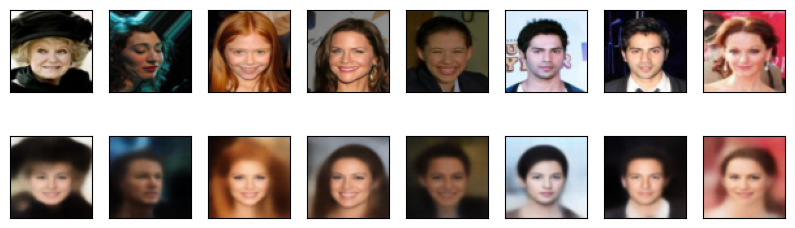

In [185]:
img = x[0].detach().cpu().squeeze().numpy()

fig, axs = plt.subplots(nrows=2, ncols=8, figsize=(10,3))
print(x.shape)
print(out.shape)
for i in range(8):
    x_img = x[i].permute(1,2,0).detach().cpu().squeeze().numpy()
    pred_img = out[i].permute(1,2,0).detach().cpu().squeeze().numpy()
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])

    axs[0, i].imshow(x_img)
    axs[1, i].imshow(pred_img)


In [186]:
z_mean_total = []
z_total = []
for step, (x, y) in enumerate(test_dl):
    x = x.to(device)
    z_mean, z_log_var, z = model.encoder(x)
    z_mean_total.extend(z_mean.detach().cpu().numpy())
    z_total.extend(z.detach().cpu().numpy())

z_mean_total = np.array(z_mean_total)
z_total = np.array(z_total)


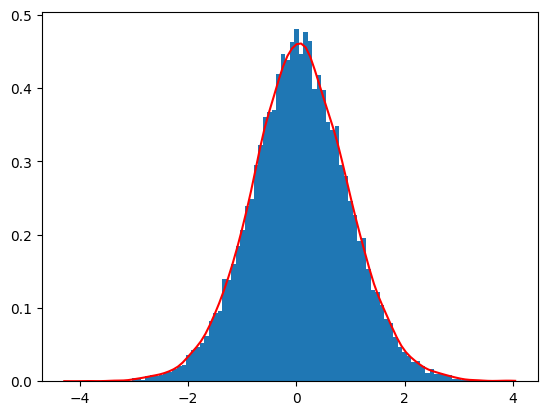

In [187]:
from scipy.stats import gaussian_kde

counts, bins, _ = plt.hist(z_mean_total[:,0], bins=100, density=True)
kde = gaussian_kde(z_mean_total[:,0])
x = np.linspace(min(bins), max(bins), 100)
plt.plot(x, kde(x), color='r')
plt.show()

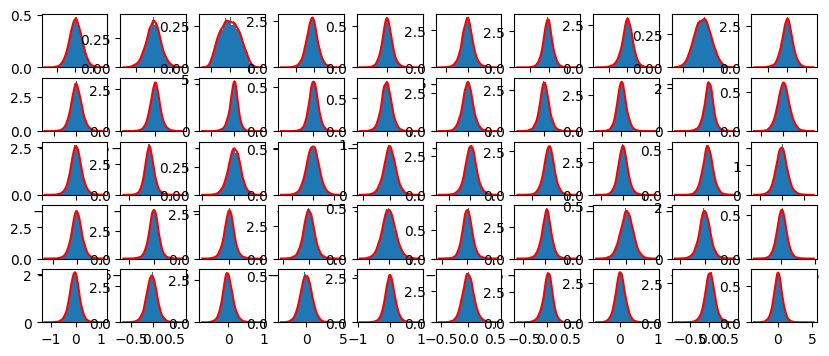

In [188]:
fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(10,4))
for i in range(50):
    row = i // 10
    col = i % 10
    
    points = z_mean_total[:,i]
    counts, bins, _ = axs[row][col].hist(points, bins=100, density=True)
    kde = gaussian_kde(points)
    x = np.linspace(min(bins), max(bins), 100)
    axs[row][col].plot(x, kde(x), color='r')
    

torch.Size([30, 3, 64, 64])


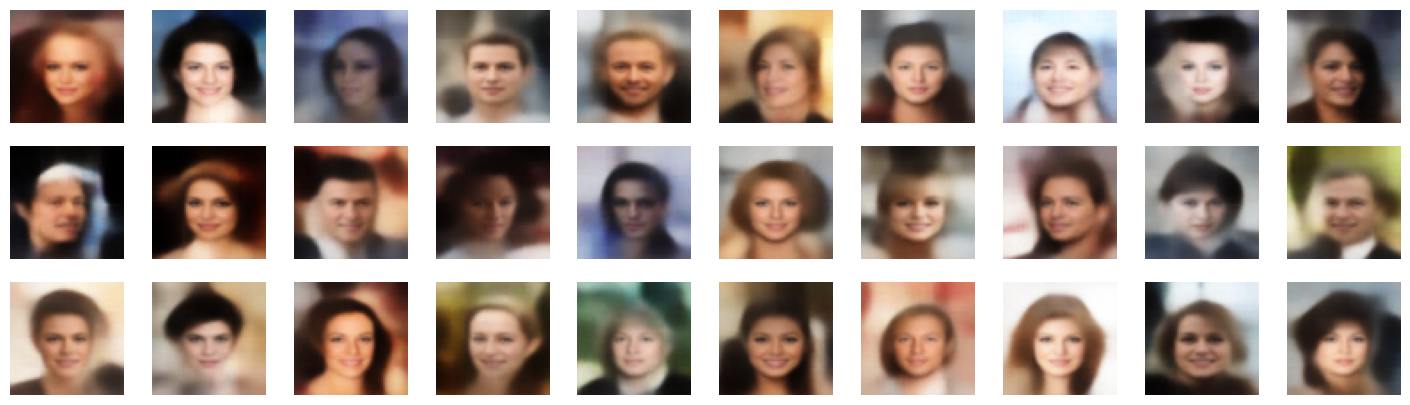

In [189]:
grid_width, grid_height = (10,3)
z_sample = torch.randn(size=(grid_width*grid_height, 200))

z_sample = z_sample.to(device)
reconstructions = decoder(z_sample)
# B C H W
print(reconstructions.shape)
reconstructions = reconstructions.permute(0,2,3,1).detach().cpu().numpy()
# B H W C


fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(grid_width*grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.imshow(reconstructions[i])


In [190]:
attrs = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young".split()
print(len(attrs))
smiling_idx = attrs.index('Smiling')
glasses_idx = attrs.index('Eyeglasses')
black_hair_idx = attrs.index('Black_Hair')

attrs_total = []
for step, (x, y) in enumerate(test_dl):    
    attrs_total.extend(y)

attrs_total = np.array(attrs_total)
print(attrs_total.shape)


40
(19962, 40)


In [191]:
smiling_img_idx = attrs_total[:, smiling_idx] == 1
smiling_feature_vector = np.mean(z_total[smiling_img_idx], axis=0)

glasses_img_idx = attrs_total[:, glasses_idx] == 1
glasses_feature_vector = np.mean(z_total[glasses_img_idx], axis=0)

black_hair_img_idx = attrs_total[:, black_hair_idx] == 1
black_hair_feature_vector = np.mean(z_total[black_hair_img_idx], axis=0)

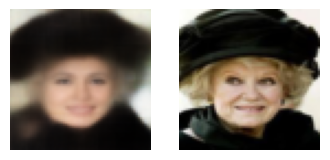

In [192]:
x, test_y = next(iter(test_dl))
x = x.to(device)
out, z_mean, z_log_var, z = model(x)
z = z.detach().cpu().numpy()
out = out[0].permute(1, 2, 0).detach().cpu().numpy()

fig = plt.figure(figsize=(4,2))

ax = fig.add_subplot(1, 2, 1)
ax.axis('off')
ax.imshow(out)

ax = fig.add_subplot(1, 2, 2)
ax.axis('off')
ax.imshow(x[0].permute(1,2,0).detach().cpu().numpy())
plt.show()

(7, 200)


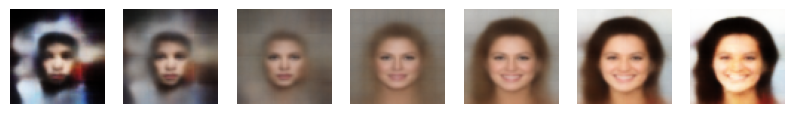

In [201]:
multipliers = np.array([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
z_new = z[0] + (multipliers.reshape(-1,1) * smiling_feature_vector)
print(z_new.shape)
z_new_tensor = torch.tensor(z_new).to(device).float()
pred = decoder(z_new_tensor)

fig = plt.figure(figsize=(10, 2))
for i in range(len(multipliers)):
    img = pred[i].permute(1,2,0).detach().cpu().numpy()
    ax = fig.add_subplot(1, len(multipliers), i+1)
    ax.axis('off')
    ax.imshow(img)

plt.show()

(7, 200)


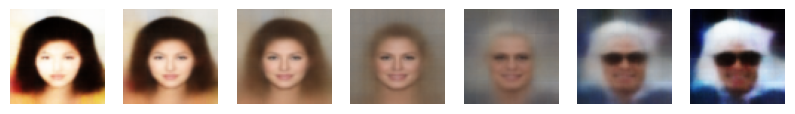

In [202]:
multipliers = np.array([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
z_new = z[0] + (multipliers.reshape(-1,1) * glasses_feature_vector)
print(z_new.shape)
z_new_tensor = torch.tensor(z_new).to(device).float()
pred = decoder(z_new_tensor)

fig = plt.figure(figsize=(10, 2))
for i in range(len(multipliers)):
    img = pred[i].permute(1,2,0).detach().cpu().numpy()
    ax = fig.add_subplot(1, len(multipliers), i+1)
    ax.axis('off')
    ax.imshow(img)

plt.show()

(7, 200)


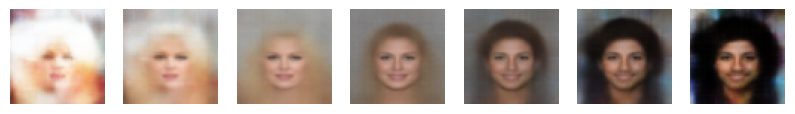

In [203]:
multipliers = np.array([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

z_new = z[0] + (multipliers.reshape(-1,1) * black_hair_feature_vector)
print(z_new.shape)
z_new_tensor = torch.tensor(z_new).to(device).float()
pred = decoder(z_new_tensor)

fig = plt.figure(figsize=(10, 2))
for i in range(len(multipliers)):
    img = pred[i].permute(1,2,0).detach().cpu().numpy()
    ax = fig.add_subplot(1, len(multipliers), i+1)
    ax.axis('off')
    ax.imshow(img)

plt.show()

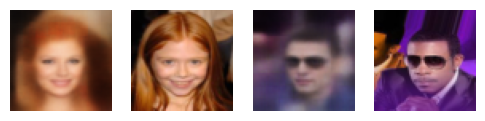

In [204]:
x, test_y = next(iter(test_dl))
x = x.to(device)
out, z_mean, z_log_var, z = model(x)
z = z.detach().cpu().numpy()
out = out.permute(0, 2, 3, 1).detach().cpu().numpy()

fig = plt.figure(figsize=(6,2))

ax = fig.add_subplot(1, 4, 1)
ax.axis('off')
ax.imshow(out[2])

ax = fig.add_subplot(1, 4, 2)
ax.axis('off')
ax.imshow(x[2].permute(1,2,0).detach().cpu().numpy())

ax = fig.add_subplot(1, 4, 3)
ax.axis('off')
ax.imshow(out[24])

ax = fig.add_subplot(1, 4, 4)
ax.axis('off')
ax.imshow(x[24].permute(1,2,0).detach().cpu().numpy())

plt.show()

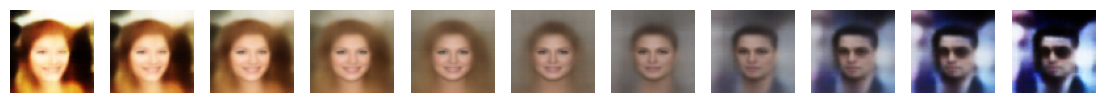

In [205]:
alpha = np.linspace(0, 1, 11).reshape(-1,1)

z_A = z[2]
z_B = z[24]
z_new = z_A * (1 - alpha) + z_B * alpha

z_new_tensor = torch.tensor(z_new).to(device).float()
pred = decoder(z_new_tensor)

fig = plt.figure(figsize=(14, 3))
for i in range(alpha.shape[0]):
    img = pred[i].permute(1,2,0).detach().cpu().numpy()
    ax = fig.add_subplot(1, alpha.shape[0], i+1)
    ax.axis('off')
    ax.imshow(img)

plt.show()